In [1]:
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the catalogs and read them
indir = "D:/HessCTA/Summer School 0624/Python/"
# indir = "./"
gamfile = "gll_psc_v31.fit"   # 4FGL-DR3
ctptfile = "SUMSS_VIII_81B.fits"
sra = "RAJ2000"
sdec = "DEJ2000"
sid = "recno"
sflux = 'St'
gamcat = Table.read(indir+gamfile, hdu=1)
# Eliminate sources with invalid localization, like extended sources
valid = np.nonzero(np.logical_not(gamcat['Conf_95_SemiMajor'].mask))[0]
print("gamma catalog:", len(valid), "entries with valid localization among", len(gamcat))
gamcat = gamcat[valid]
ctptcat = Table.read(indir+ctptfile, hdu=1)
print("counterpart catalog:", len(ctptcat), "entries")
# Set coordinate units (absent in the FITS file)
for colname in (sra,sdec):
  ctptcat[colname].unit = "deg"

gamma catalog: 6579 entries with valid localization among 6659
counterpart catalog: 211050 entries


In [3]:
# Get Galactic coordinates
ctptdir = SkyCoord(ra=ctptcat[sra], dec=ctptcat[sdec])
galdir = ctptdir.galactic

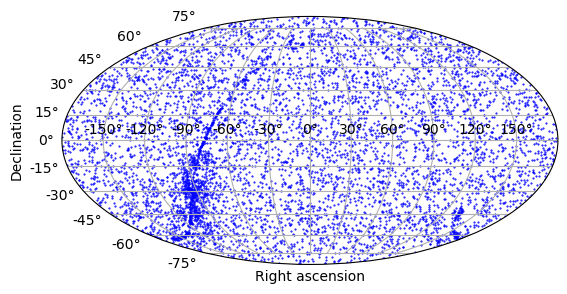

In [4]:
# Show gamma-ray source positions in the sky
# Note that the RA axis is not inverted
ra = np.mod(gamcat[sra]+180,360) - 180
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide' ) # or hammer, aitoff, ...
ax.scatter(np.radians(ra), np.radians(gamcat[sdec]), marker='.', s=1, color='b')
ax.grid(True)
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.show()

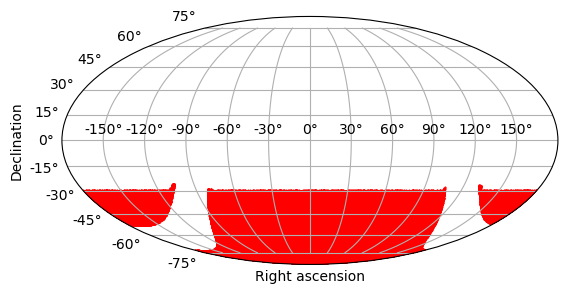

In [5]:
# Show counterpart source positions in the sky
ra2 = np.mod(ctptcat[sra]+180,360) - 180
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide' ) # or hammer, aitoff, ...
ax.scatter(np.radians(ra2), np.radians(ctptcat[sdec]), marker='.', s=1, color='r')
ax.grid(True)
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.show()

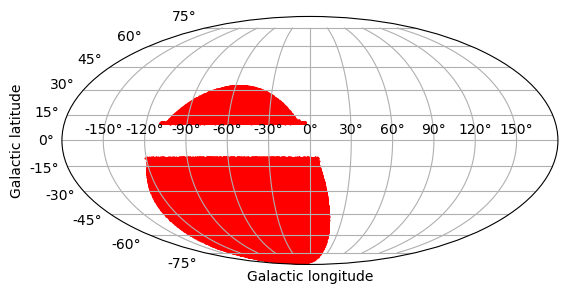

In [6]:
# Check counterpart source positions in Galactic coordinates as well
glon2 = np.mod(galdir.l.degree+180,360) - 180
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide' ) # or hammer, aitoff, ...
ax.scatter(np.radians(glon2), galdir.b.radian, marker='.', s=1, color='r')
ax.grid(True)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.show()

Sin(-50°) = -0.766044443118978


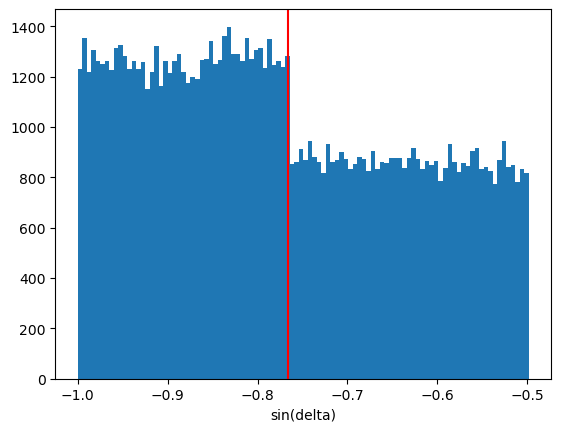

In [7]:
# Check density vs declination, avoiding regions close to the Galactic plane
ctpthighlat = np.nonzero(np.abs(ra2) < 70)[0]
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist(np.sin(np.radians(ctptcat[ctpthighlat][sdec])), bins=100)
sin50 = np.sin(np.radians(-50))
print("Sin(-50°) =", sin50)
ax.axvline(sin50, color='r')
h = plt.xlabel('sin(delta)')

In [8]:
# Check minimum source flux above and below -50°
lowdec = np.nonzero(ctptcat[sdec] < -55)[0]
middec = np.nonzero(ctptcat[sdec] > -45)[0]
print("delta < -55°: Flux between", np.min(ctptcat[lowdec][sflux]), np.max(ctptcat[lowdec][sflux]), "mJy")
print("delta > -45°: Flux between", np.min(ctptcat[middec][sflux]), np.max(ctptcat[middec][sflux]), "mJy")

delta < -55°: Flux between 6.0 25055.4 mJy
delta > -45°: Flux between 10.0 342000.0 mJy


In [9]:
# Force same detection limit everywhere
fluxmin = 15
notfaint = np.nonzero(ctptcat[sflux] > fluxmin)[0]
ncat2 = len(notfaint)
print(ncat2, "counterparts above", fluxmin,"mJy")
ctptcat2 = ctptcat[notfaint]

140111 counterparts above 15 mJy


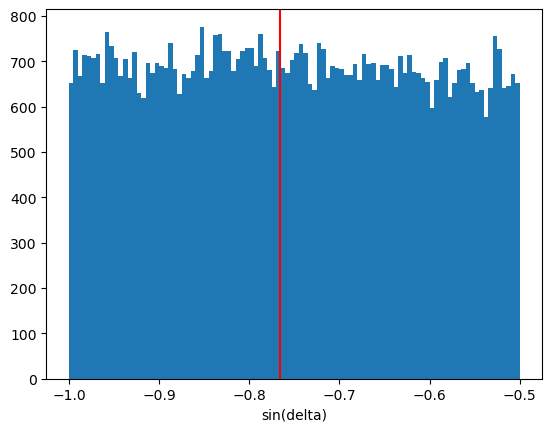

In [10]:
# Check again density vs declination, avoiding regions close to the Galactic plane
decmax = -30
ctpthighlat = np.nonzero(np.logical_and(np.abs(ra2[notfaint]) < 70, ctptcat2[sdec] < decmax))[0]
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist(np.sin(np.radians(ctptcat2[ctpthighlat][sdec])), bins=100)
ax.axvline(sin50, color='r')
h = plt.xlabel('sin(delta)')

In [11]:
# Deduce average source density
cosmin = np.cos(np.radians(-90-decmax))
rho = len(ctpthighlat) / (2*np.pi*(1-cosmin)*7/18) * (np.pi/180)**2
print("Counterpart density =", rho, " per square degree")

Counterpart density = 17.124422622317514  per square degree


In [12]:
# Select gamma sources at high latitude, declination below -30°
highlat = np.nonzero(np.logical_and(np.abs(gamcat['GLAT']) > 10, gamcat[sdec] < decmax))[0]
nhighlat = len(highlat)
print("Gamma sources at |b| > 10° and dec <", decmax, ":", nhighlat)
gamcath = gamcat[highlat]

Gamma sources at |b| > 10° and dec < -30 : 1169


In [13]:
# Get closest neighbor
gamdir = SkyCoord(ra=gamcath[sra], dec=gamcath[sdec])
idx, d2d, d3d = gamdir.match_to_catalog_sky(ctptdir[notfaint])
print("First match:",gamcath[0]['Source_Name'],ctptcat[notfaint[idx[0]]][sid])

First match: 4FGL J0000.3-7355  115


In [14]:
f95 = np.sqrt(-2*np.log(0.05))
print("f95 =", f95)
# Replace error ellipses by circles for simplicity
gamlocerr = np.sqrt(gamcath['Conf_95_SemiMajor']*gamcath['Conf_95_SemiMinor']) / f95
# Check the median localization error
medgamlocerr = np.median(gamlocerr)
print("Median gamma localization error:", medgamlocerr*60, " arcmin")

f95 = 2.4477468306808166
Median gamma localization error: 1.4774658903479576  arcmin


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.03830392067041125 73.51488464521566


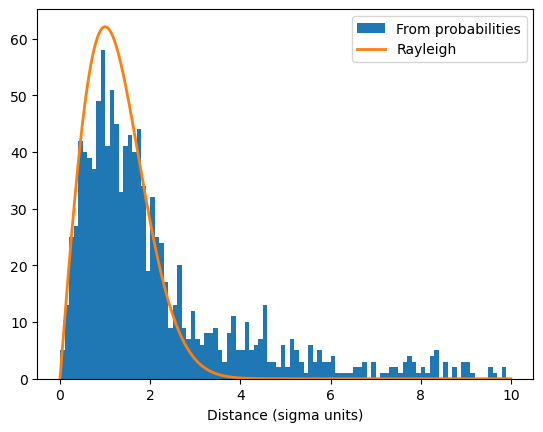

In [15]:
# Show histogram of distance values in sigma units
reldist = d2d.degree / gamlocerr.data
print(np.min(reldist), np.max(reldist))
nok = np.count_nonzero(reldist < 5)
fig = plt.figure()
ax = fig.add_subplot(111)
rdmax = 10
nbins = 100
rdbin = rdmax / nbins
counts, bins, patches = ax.hist(reldist, range=(0,rdmax), bins=nbins, label='From probabilities')
# Overlay Rayleigh distribution
xrd = np.linspace(0,rdmax,1000)
yrd = rdbin * xrd * np.exp(-xrd**2/2)
h = ax.plot(xrd, nok*yrd, lw=2, label='Rayleigh')
ax.legend()
h = plt.xlabel('Distance (sigma units)')

In [16]:
# Now define and compute the quantities necessary for the associations
beta = 0.8
Kctpt = (2*np.pi*rho) * gamlocerr.data**2
argexp = (1 - Kctpt) * reldist**2 / 2
# Eliminate sources with too many counterparts in the error radius or LR = 0 (counterpart very far)
goodloc = np.nonzero(np.logical_and(Kctpt < 1, argexp < 100))[0]
Kctpt0 = Kctpt[goodloc]
print(len(goodloc), "associable sources")
LR = np.exp(-argexp[goodloc]) / Kctpt0
print(np.min(LR), np.max(LR))
Gamma = np.power(10,np.linspace(-4,1,500))
alpha = 1 / (Gamma * (1/beta-1))
probas = 1 / (1 + 1/np.outer(Gamma,LR))
print(probas.shape,np.min(probas),np.max(probas))

1127 associable sources
1.295087963369774e-41 788.6066363624257
(500, 1127) 1.2950879633697742e-45 0.9998732101450785


In [17]:
# Apply probabilities larger than probmin to get probabilities of false association
posfalse = np.where(probas > beta, 1-probas, 0)
print(np.amax(posfalse))
# Deduce the "true" number of false positives as a function of Gamma
falseT = np.sum(posfalse, axis=1)
print(np.min(falseT), np.max(falseT))

0.199999166492708
0.0 44.84758576325134


In [18]:
# Set maximum on K alpha to avoid negatives
Kalpha = np.minimum(np.outer(alpha,Kctpt0),1)
# Get expected number of sources inside Rmax by chance
numR = - np.log(Kalpha) / (1/Kctpt0 - 1)
print(np.min(numR), np.max(numR))
# Get expected number of false positives by chance
falseR = np.sum(1-np.exp(-numR), axis=1)
print(np.min(falseR), np.max(falseR))
# Get number of recognized associations as a function of Gamma
nrecs = np.count_nonzero(probas > beta, axis=1)

-0.0 27.201350335066937
0.0 330.54571440506106


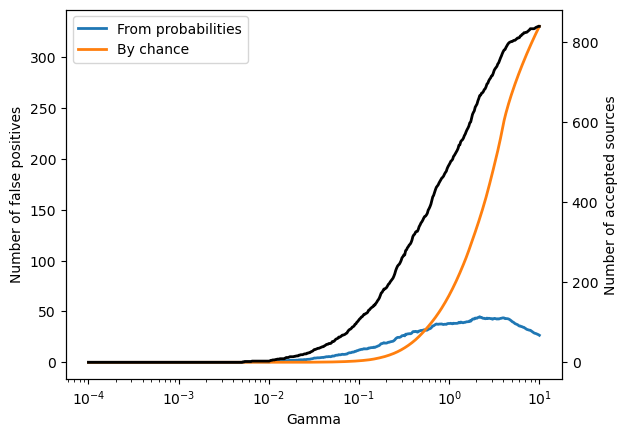

In [19]:
# Plot the curves and solve for Gamma
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.plot(Gamma, falseT, lw=2, label='From probabilities')
h = ax.plot(Gamma, falseR, lw=2, label='By chance')
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_xlabel('Gamma')
ax.set_ylabel('Number of false positives')
ax2 = ax.twinx()
h = ax2.plot(Gamma, nrecs, lw=2, color='k')
h = ax2.set_ylabel('Number of accepted sources')

In [20]:
# Deduce the best value of Gamma
# Take relative difference to avoid solution near 0
ibestG = np.argmin(np.abs(falseT/falseR-1))
nfalsepos = falseT[ibestG]
Gambest = Gamma[ibestG]
ProbH1 = 1 / (1 + 1/Gambest)
print("Best Gamma =", Gambest,"corresponding to Pr(H1) =", ProbH1)
print(nfalsepos, "false positives")
# Now get individual probilities of associations
probassoc = np.zeros(len(gamcath))
probassoc[goodloc] = probas[ibestG,:]
# Now get list of positive associations
recassoc = np.nonzero(probassoc > beta)[0]
nrec = len(recassoc)
print(nrec, "recognized associations corresponding to a fraction of", nrec/len(gamcath))

Best Gamma = 0.5463550352214875 corresponding to Pr(H1) = 0.35331797858648417
31.60333513191333 false positives
365 recognized associations corresponding to a fraction of 0.31223267750213857


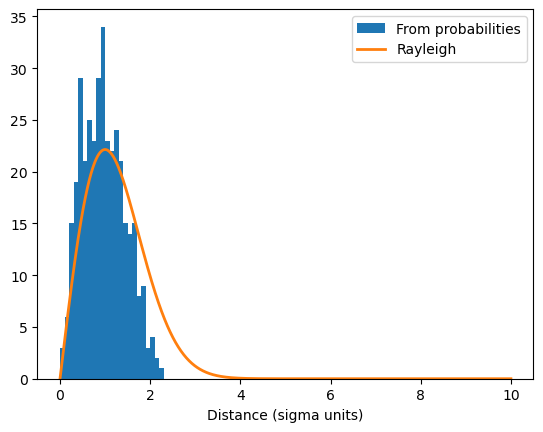

In [21]:
# Redo the Rayleigh plot for those
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist(reldist[recassoc], range=(0,rdmax), bins=nbins, label='From probabilities')
h = ax.plot(xrd, nrec*yrd, lw=2, label='Rayleigh')
ax.legend()
h = plt.xlabel('Distance (sigma units)')

In [22]:
# Get total estimate of true associations
ntrueest = np.sum(probassoc)
print("Total true:", ntrueest, "True recognized:", nrec-nfalsepos, "Fraction:", (nrec-nfalsepos)/ntrueest)

Total true: 602.3407513888232 True recognized: 333.39666486808665 Fraction: 0.5535017580985025


[3.42000e+05 1.05805e+05 1.04658e+05 ... 1.51000e+01 1.51000e+01
 1.51000e+01]


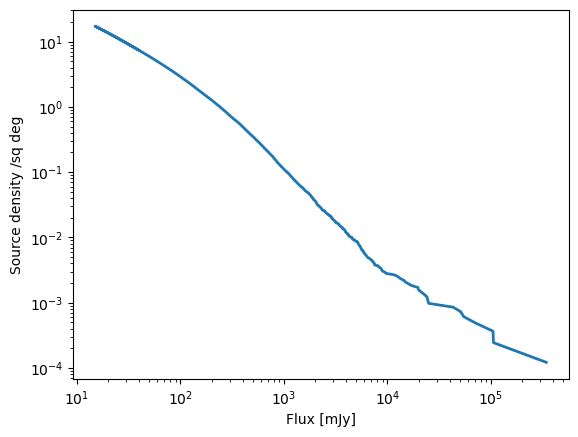

In [23]:
# Sort the catalog as a function of decreasing flux
scat2 = np.flip(np.sort(ctptcat2, order=sflux))
print(scat2[sflux])
# Number of sources above each source flux is just the index in the sorted array
# (this does not handle equal values correctly)
rho2 = np.arange(1, ncat2+1) / ncat2 * rho
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.plot(scat2[sflux], rho2, lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
h = plt.xlabel('Flux [mJy]')
h = plt.ylabel('Source density /sq deg')

In [24]:
# Find all neighbors within 0.5 deg (expect more than 10 on average)
cat2dir = SkyCoord(ra=scat2[sra]*u.degree, dec=scat2[sdec]*u.degree)
idx1, idx2, d2dall, d3d = search_around_sky(gamdir, cat2dir, 0.5*u.degree)
print(len(idx1), "pairs within 0.5 degrees")

16883 pairs within 0.5 degrees


In [25]:
# compute LR for all pairs
rdall = d2dall.degree / gamlocerr[idx1].data
print(np.min(rdall), np.max(rdall))
Kall = (2*np.pi) * rho2[idx2] * gamlocerr[idx1].data**2
print(np.min(Kall), np.max(Kall))
LRall = np.exp(-rdall**2/2) / Kall
print(np.min(LRall), np.max(LRall))

0.038303920449220576 154.84237905277655
3.508047075244887e-08 7.0534012014454355
0.0 7453665.159942541


-26.18282500262716 1.1152108824456242


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


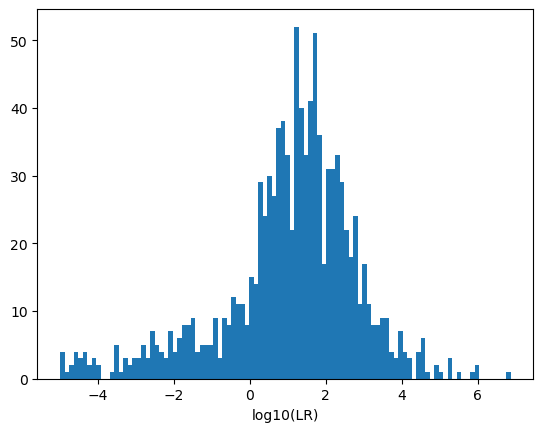

In [26]:
# Sort by decreasing LRall
sLRall = np.flip(np.argsort(LRall))
# Keep only unique gamma sources
idxs, ind0 = np.unique(idx1[sLRall], return_index=True)
ind0 = sLRall[ind0]
LRbest = LRall[ind0]
print(np.median(np.log10(LRall[LRall>0])), np.median(np.log10(LRbest[LRbest>0])))
# Plot the histogram of log10(likelihood ratio) values
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist(np.log10(LRbest[LRbest>1e-5]), bins=100)
h = plt.xlabel('log10(LR)')

0.5000114081020525 0.9999938636351897
39420  random points in covered region. Multiplicity 33 . Final number 38577


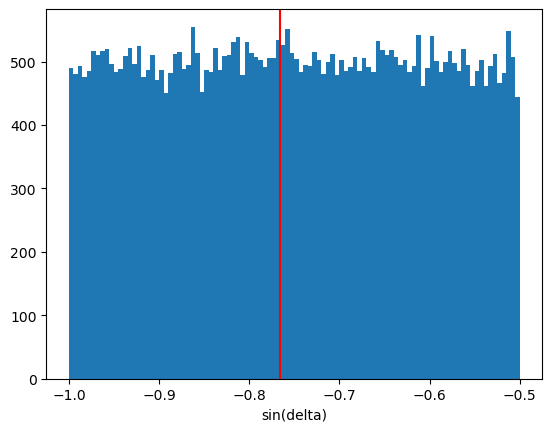

In [27]:
# Simulate a large number of gamma-ray sources randomly
nrand = 50000
rng = np.random.default_rng()
# Invert uniform distribution on cumulative distribution function
costheta = rng.uniform(1-cosmin, 1, nrand)
print(np.min(costheta), np.max(costheta))
deltar = -90 + np.degrees(np.arccos(costheta))   # We simulate the south sky
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist(np.sin(np.radians(deltar)), bins=100)
ax.axvline(sin50, color='r')
h = plt.xlabel('sin(delta)')
rar = rng.uniform(-180, 180, nrand)
randir = SkyCoord(ra=rar*u.degree, dec=deltar*u.degree)
rangal = randir.galactic
okr = np.nonzero(np.abs(rangal.b.degree) > 10)[0]
nmult = np.floor_divide(len(okr), nhighlat)
nokr = nhighlat * nmult
print(len(okr), " random points in covered region. Multiplicity", nmult, ". Final number", nokr)
randir = randir[0:nokr-1]

In [28]:
# Proceed as before for the random positions
rdx1, rdx2, d2dr, d3d = search_around_sky(randir, cat2dir, 0.5*u.degree)
print(len(rdx1), "pairs within 0.5 degrees")
rdx1l = np.mod(rdx1, nhighlat)     # For localization error
# compute LR for all pairs
rdr = d2dr.degree / gamlocerr[rdx1l].data
print(np.min(rdr), np.max(rdr))
Kran = (2*np.pi) * rho2[rdx2] * gamlocerr[rdx1l].data**2
print(np.min(Kran), np.max(Kran))
LRr = np.exp(-rdr**2/2) / Kran
print(np.min(LRr), np.max(LRr))
# Sort by decreasing LRr
sLRr = np.flip(np.argsort(LRr))
# Keep only unique gamma sources
idxs, indr = np.unique(rdx1[sLRr], return_index=True)
indr = sLRr[indr]
LRbr = LRr[indr]
print(np.median(np.log10(LRr[LRr>0])), np.median(np.log10(LRbr[LRbr>0])))

409695 pairs within 0.5 degrees
0.020433830494361125 155.77159783197925
1.2427485761546815e-07 7.044476696690192
0.0 19036.059657174213
-29.666764177587595 -2.6321173152421364


(2, 100)


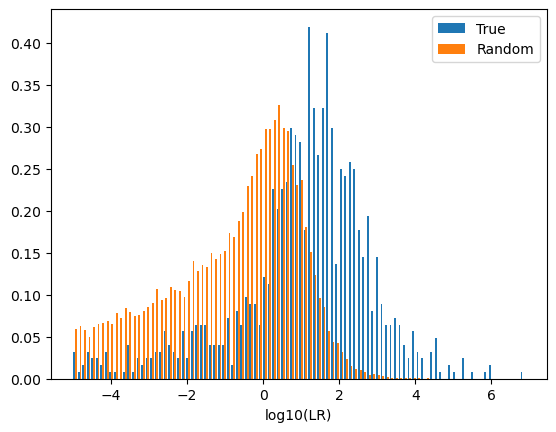

In [29]:
# Plot the density histograms of likelihood ratio values
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, patches = ax.hist((np.log10(LRbest[LRbest>1e-5]), np.log10(LRbr[LRbr>1e-5])), 
                                 density=True, bins=100, label=('True','Random'))
ax.legend()
h = plt.xlabel('log10(LR)')
print(counts.shape)

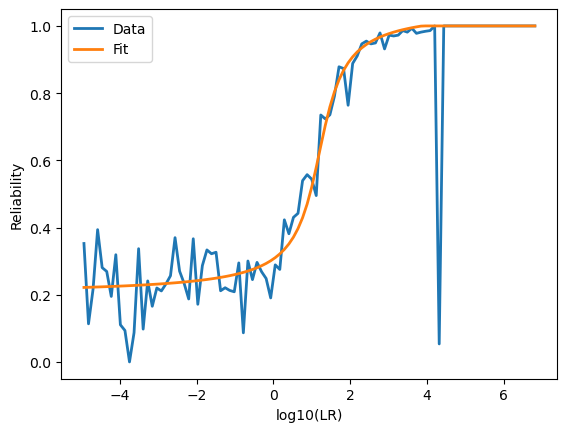

In [30]:
# Deduce binned reliability
Relbin = 1 / (1 + counts[1,:]/np.maximum(counts[0,:],1/nokr))
# Show curve
bLRcen = (bins[0:100]+bins[1:101]) / 2
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.plot(bLRcen, Relbin, lw=2, label='Data')
# Overlay arctan function
Relmin = 0.2
Relmax = 1.05
Relfit = np.minimum((Relmax+Relmin)/2 + (Relmax-Relmin)/np.pi * np.arctan(2*(bLRcen-1.2)), 1)
ax.plot(bLRcen, Relfit, lw=2, label='Fit')
ax.legend()
h = plt.xlabel('log10(LR)')
h = plt.ylabel('Reliability')